# Disclaimer

This can only properly be run on a heavy duty PC

In [1]:
training_rows_to_read = 100000 # This needs to be 15000000

# Imports

In [2]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

Preprocessing successfully imported.


In [3]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = training_rows_to_read)["train"]
print(training_data.columns)

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [4]:
training_data = preprocessing.basic_preprocessing(training_data)

Finished parse_datetime_columns
Finished create_delivery_calendar_days
Finished clean_zip_codes


In [5]:
training_data["delivery_calendar_days"].describe()

count    100000.000000
mean          4.760280
std           3.067802
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max         101.000000
Name: delivery_calendar_days, dtype: float64

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 57971
declared_handling_days : 11
acceptance_scan_timestamp : 88902
shipment_method_id : 17
shipping_fee : 1700
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 16089
buyer_zip : 19592
category_id : 33
item_price : 6518
quantity : 28
payment_datetime : 99878
delivery_date : 667
weight : 318
weight_units : 1
package_size : 5
record_number : 100000
delivery_calendar_days : 82
cleaned_item_zip : 15432
cleaned_buyer_zip : 19454
distance_between_pincodes : 98194


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : "numerical",
    "carrier_max_estimate"   : "numerical",
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
    "cleaned_item_zip" : 30743,
    "cleaned_buyer_zip" : 34876,
    "distance_between_pincodes" : "numerical",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (100000, 23)
training_data.shape after :  (100000, 76)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Pruning outliers, 1%

In [10]:
columns_to_prune = {
    "shipping_fee" : 0.01,
    "item_price" : 0.001,
    "distance_between_pincodes" : 0.001,
    "quantity" : 0.01,
    "weight" : 0.01,
    "delivery_calendar_days" : 0.01, 
    # This is obviously problematic. Maybe we should have a model that diffrentiates outliers in the target
    
    
}

In [11]:
def removeOutliers(data, columns_to_prune):# This is fundamentally flawed because the thresholds to be pruned should have been calculated earlier not after pruning one or two coloumns.
    for col in columns_to_prune.keys():
        print("col : ", col)
        min_and_max = data[col].quantile([columns_to_prune[col], (1-columns_to_prune[col])]).values
        all_rows_to_drop = np.append(np.where(data[col] > min_and_max[1])[0], np.where(data[col] < min_and_max[0])[0])
#         print("all_rows_to_drop : ", all_rows_to_drop)
        print("all_rows_to_drop.shape : ", all_rows_to_drop.shape)
#         return all_rows_to_drop
        data.drop(all_rows_to_drop, inplace=True)
        print("After dropping rows shape is :", data.shape)
        data.reset_index(inplace = True, drop = True)
#         data[col] = np.where(data[col] > upper_limit, upper_limit, data[col])
#         data[col] = np.where(data[col] < lower_limit, lower_limit, data[col])
    return data

In [12]:
training_data = removeOutliers(data = training_data, columns_to_prune=columns_to_prune)

col :  delivery_calendar_days
all_rows_to_drop.shape :  (1414,)
After dropping rows shape is : (98586, 76)


### Results and observations

Choosing a custom percentage to crop off for each column will almost certainlycome in handy.

The obvious problem is to detect outliers in delivery_calendar_days.

Loss is reduced after we drop outliers from all the column not only delivery_calendar_days.

Not sure how to deal with that yet. But one thing to keep in mind is that since the evaluation is not a squared metric, we can be allowed to have a small section of the data be wildly off. If the evaluation was squared then this small section would have had a huge impact on the loss. 

## Running a gradient boosted decision tree model

In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Custom evaluation function

In [14]:
def customLossFunctionEval(y_true, y_pred):
    residual = (y_true - y_pred).astype(np.float32)
    loss = np.where(residual < 0, 0.4 * (residual), 0.6 * (residual))
#     return np.mean(loss)
    return "Custom Loss Function", np.mean(loss), False

In [15]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((66052, 65), (32534, 65), (66052,), (32534,))

In [16]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=(x_test,y_test),
          verbose=10,eval_metric=customLossFunctionEval)# This loss needs to mirror the loss that Ebay is using.

/home/swagget/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 3.42803	valid_0's Custom Loss Function: 0.150281
[20]	valid_0's l2: 3.33632	valid_0's Custom Loss Function: 0.147612
[30]	valid_0's l2: 3.31245	valid_0's Custom Loss Function: 0.147075
[40]	valid_0's l2: 3.30567	valid_0's Custom Loss Function: 0.146814
[50]	valid_0's l2: 3.30178	valid_0's Custom Loss Function: 0.146769
[60]	valid_0's l2: 3.30146	valid_0's Custom Loss Function: 0.146551
[70]	valid_0's l2: 3.30193	valid_0's Custom Loss Function: 0.14649
[80]	valid_0's l2: 3.30247	valid_0's Custom Loss Function: 0.14649
[90]	valid_0's l2: 3.30245	valid_0's Custom Loss Function: 0.146367
[100]	valid_0's l2: 3.30276	valid_0's Custom Loss Function: 0.146303


LGBMRegressor(max_depth=-5, random_state=42)

# Evaluating the model

In [17]:
model_test_outputs = model.predict(x_test)

In [18]:
pd.Series(model_test_outputs).describe()

count    32534.000000
mean         4.586210
std          0.839301
min          2.846225
25%          4.125033
50%          4.408917
75%          4.828699
max         11.697230
dtype: float64

In [19]:
customLossFunctionEval(y_true = y_test, y_pred = model_test_outputs)

('Custom Loss Function', 0.14630327, False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

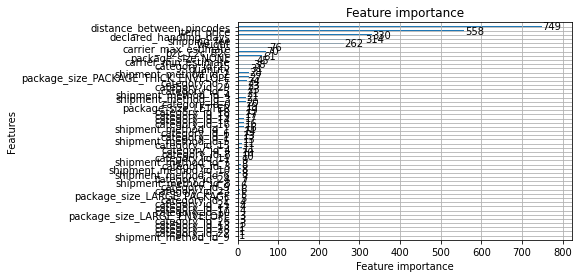

In [20]:
lgb.plot_importance(model)

In [21]:
feature_importances = {}

for importance, feature in zip(model.feature_importances_, model.feature_name_):
    feature_importances[feature] = importance

feature_importances

{'declared_handling_days': 330,
 'shipping_fee': 314,
 'carrier_min_estimate': 45,
 'carrier_max_estimate': 76,
 'item_price': 558,
 'quantity': 31,
 'weight': 262,
 'distance_between_pincodes': 749,
 'b2c_c2c_B2C': 70,
 'b2c_c2c_C2C': 0,
 'shipment_method_id_0': 0,
 'shipment_method_id_3': 21,
 'shipment_method_id_1': 16,
 'shipment_method_id_5': 13,
 'shipment_method_id_2': 28,
 'shipment_method_id_6': 8,
 'shipment_method_id_8': 7,
 'shipment_method_id_10': 8,
 'shipment_method_id_7': 9,
 'shipment_method_id_4': 21,
 'shipment_method_id_13': 0,
 'shipment_method_id_14': 0,
 'shipment_method_id_9': 1,
 'shipment_method_id_11': 0,
 'shipment_method_id_12': 0,
 'shipment_method_id_15': 0,
 'shipment_method_id_24': 0,
 'category_id_13': 3,
 'category_id_0': 20,
 'category_id_1': 13,
 'category_id_3': 8,
 'category_id_11': 10,
 'category_id_18': 19,
 'category_id_12': 0,
 'category_id_8': 10,
 'category_id_5': 23,
 'category_id_10': 4,
 'category_id_23': 6,
 'category_id_9': 6,
 'categor

In [22]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.2172
Testing accuracy 0.1767


In [23]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [24]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [25]:
raise

RuntimeError: No active exception to reraise

In [ ]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 10000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


In [ ]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [ ]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [ ]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

In [ ]:
submission